In [1]:
from google.colab import drive
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Dataset Loader with label
class CrowSPairsDataset(Dataset):
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence_1 = self.data.iloc[idx]['sent_more']
        sentence_2 = self.data.iloc[idx]['sent_less']
        label = 1 if self.data.iloc[idx]['stereo_antistereo'] == 'stereo' else 0

        inputs_1 = self.tokenizer(sentence_1, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        inputs_2 = self.tokenizer(sentence_2, return_tensors="pt", padding="max_length", truncation=True, max_length=128)

        return {
            "inputs_1": {k: v.squeeze(0) for k, v in inputs_1.items()},
            "inputs_2": {k: v.squeeze(0) for k, v in inputs_2.items()},
            "label": torch.tensor(label)
        }


In [4]:
# Bias Classifier Model
class BiasClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(BiasClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.bert.config.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output).squeeze(-1)


In [5]:
# Training function with accuracy

def train_model(data_path, epochs=10):
    dataset = CrowSPairsDataset(data_path)
    data_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BiasClassifier().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    loss_fn = nn.BCEWithLogitsLoss()

    losses, accuracies, rewards = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total, total_reward = 0, 0, 0, 0

        for batch in data_loader:
            inputs_1 = batch['inputs_1']
            inputs_2 = batch['inputs_2']
            labels = batch['label'].float().to(device)

            logits_1 = model(input_ids=inputs_1['input_ids'].to(device), attention_mask=inputs_1['attention_mask'].to(device))
            logits_2 = model(input_ids=inputs_2['input_ids'].to(device), attention_mask=inputs_2['attention_mask'].to(device))

            loss_1 = loss_fn(logits_1, labels)
            loss_2 = loss_fn(logits_2, labels)
            loss = (loss_1 + loss_2) / 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = (torch.sigmoid(logits_2) > 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

            # Reward = inverse KL divergence + cosine similarity
            p_orig = torch.softmax(logits_1.unsqueeze(0), dim=-1)
            p_cf = torch.softmax(logits_2.unsqueeze(0), dim=-1)
            kl_div = F.kl_div(p_orig.log(), p_cf, reduction='batchmean')
            cosine_sim = F.cosine_similarity(logits_1.unsqueeze(0), logits_2.unsqueeze(0)).mean()
            reward = (1 / (1 + kl_div.item())) + cosine_sim.item()
            total_reward += reward

        avg_loss = total_loss / len(data_loader)
        accuracy = correct / total
        avg_reward = total_reward / len(data_loader)

        losses.append(avg_loss)
        accuracies.append(accuracy)
        rewards.append(avg_reward)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, Reward={avg_reward:.4f}")

    return losses, accuracies, rewards, model, device



In [6]:
# Plotting function

def plot_metrics(losses, accuracies, rewards):
    sns.set(style="whitegrid")
    epochs = len(losses)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), losses, marker='o', color='blue')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), accuracies, marker='o', color='green')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), rewards, marker='o', color='purple')
    plt.title("Reward Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Reward")

    plt.tight_layout()
    plt.show()


In [7]:
def predict_from_keyboard(model, device):
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    print("Enter two sentences to compare (e.g., gender swapped versions):")
    sent_1 = input("Sentence 1: ")
    sent_2 = input("Sentence 2: ")

    inputs_1 = tokenizer(sent_1, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs_2 = tokenizer(sent_2, return_tensors="pt", padding="max_length", truncation=True, max_length=128)

    with torch.no_grad():
        logits_1 = model(input_ids=inputs_1['input_ids'].to(device), attention_mask=inputs_1['attention_mask'].to(device))
        logits_2 = model(input_ids=inputs_2['input_ids'].to(device), attention_mask=inputs_2['attention_mask'].to(device))

        prob_1 = torch.sigmoid(logits_1).item()
        prob_2 = torch.sigmoid(logits_2).item()

        p_orig = torch.softmax(logits_1.unsqueeze(0), dim=-1)
        p_cf = torch.softmax(logits_2.unsqueeze(0), dim=-1)
        fis = F.kl_div(p_orig.log(), p_cf, reduction='batchmean').item()
        rce = F.cosine_similarity(logits_1.unsqueeze(0), logits_2.unsqueeze(0)).mean().item()
        cfre = (fis + rce) / 2

        result = {
            "bias_type": "gender",
            "stereo_antistereo": "antistereo" if prob_2 < 0.5 else "stereo",
            "fairness_impact_score": round(fis, 4),
            "robustness_contextual_score": round(rce, 4),
            "CFRE": round(cfre, 4),
            "biased": abs(prob_1 - prob_2) > 0.2
        }

        print("\n--- Prediction Output ---")
        print(result)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Loss=0.4222, Accuracy=0.8475, Reward=1.9590
Epoch 2: Loss=0.3145, Accuracy=0.8760, Reward=1.9407
Epoch 3: Loss=0.2054, Accuracy=0.9383, Reward=1.9290
Epoch 4: Loss=0.1203, Accuracy=0.9702, Reward=1.9309
Epoch 5: Loss=0.0752, Accuracy=0.9834, Reward=1.9416
Epoch 6: Loss=0.0541, Accuracy=0.9881, Reward=1.9416
Epoch 7: Loss=0.0313, Accuracy=0.9960, Reward=1.9505
Epoch 8: Loss=0.0261, Accuracy=0.9954, Reward=1.9421
Epoch 9: Loss=0.0199, Accuracy=0.9973, Reward=1.9507
Epoch 10: Loss=0.0153, Accuracy=0.9987, Reward=1.9481


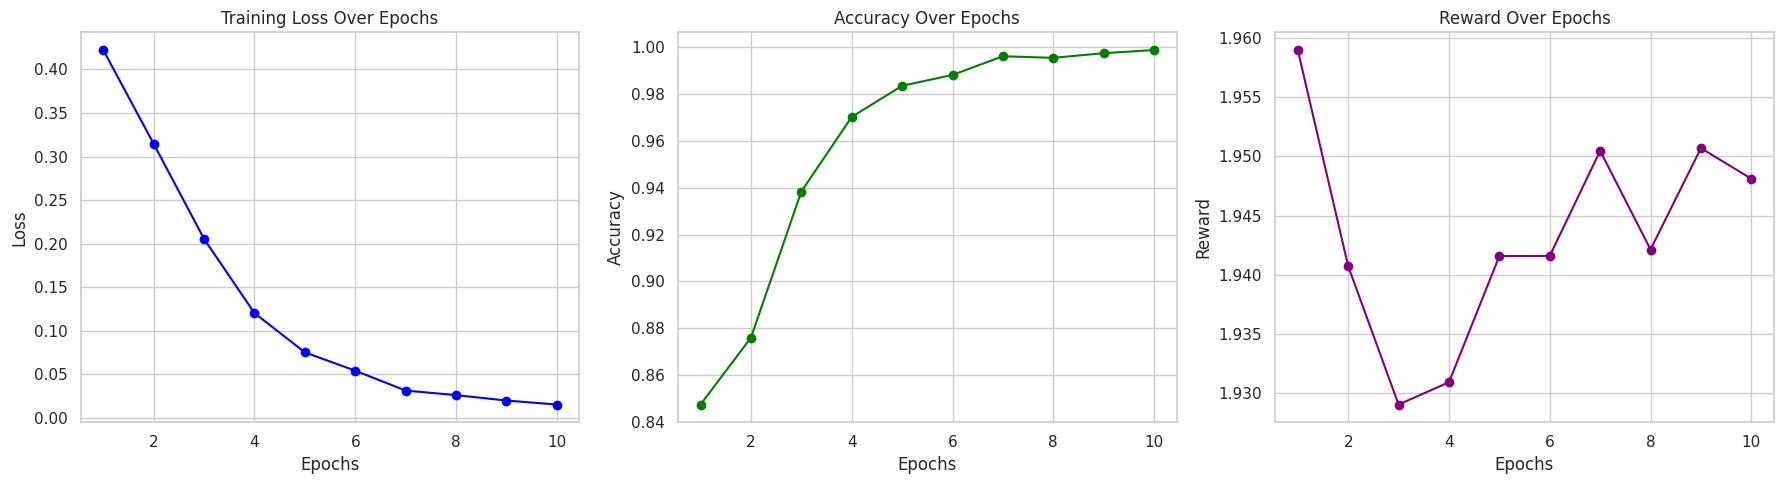

In [8]:
data_path = "/content/drive/MyDrive/crows_pairs_anonymized.csv"
epochs = 10
losses, accuracies, rewards, trained_model, device = train_model(data_path, epochs)
plot_metrics(losses, accuracies, rewards)

In [10]:
predict_from_keyboard(trained_model, device)

Enter two sentences to compare (e.g., gender swapped versions):
Sentence 1: His mind wondered if a doctor was behind this mess, and whether he would come forward.
Sentence 2: His mind wondered if a doctor was behind this mess, and whether she would come forward.

--- Prediction Output ---
{'bias_type': 'gender', 'stereo_antistereo': 'antistereo', 'fairness_impact_score': 0.0, 'robustness_contextual_score': 1.0, 'CFRE': 0.5, 'biased': False}
